## 說明：fit

In [1]:
# 載入所需套件
import numpy as np
import pandas as pd 
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

In [2]:
# you can select water_quality or water_potability
Dataset = 'water_potability'

## Load Dataset and Prepocess

In [3]:
def Load_Preprocess_WQ():
    # 水質資料集
    data = './dataset/waterQuality1.csv'
    df = pd.read_csv(data)
    
    # 刪除缺失值
    df.drop(df[df['is_safe'] == "#NUM!"].index, inplace=True)
    # 分割特徵與標籤
    X = df.drop(columns=['is_safe'])  # Features
    y = df['is_safe']  # Target
    #分割訓練集與測試集
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,shuffle=True)
    # 資料類型轉換 使用pd.to_numeric轉換成數字類型，
    y_train = pd.to_numeric(y_train, errors='coerce')
    y_test = pd.to_numeric(y_test, errors='coerce')
    X_train['ammonia'] = pd.to_numeric(X_train['ammonia'], errors='coerce')
    X_test['ammonia'] = pd.to_numeric(X_test['ammonia'], errors='coerce')
    # 設定特徵名稱
    
    feature_names = X.columns
    X_train = pd.DataFrame(X_train, columns=feature_names)
    X_test = pd.DataFrame(X_test, columns=feature_names) 
    return df, X_train, X_test, y_train, y_test


def Load_Preprocess_PT():
    # 水質資料集
    # 可飲用性資料集
    df = pd.read_csv("./dataset/water_potability.csv")
    
    # 以分群特徵平均值處理缺失值
    df['ph']=df['ph'].fillna(df.groupby(['Potability'])['ph'].transform('mean'))
    df['Sulfate']=df['Sulfate'].fillna(df.groupby(['Potability'])['Sulfate'].transform('mean'))
    df['Trihalomethanes']=df['Trihalomethanes'].fillna(df.groupby(['Potability'])['Trihalomethanes'].transform('mean'))
    
    # 將資料分成特徵(X)與標籤(y)
    # Potability為目標(y)欄位故從X中移除
    X = df.drop(["Potability"], axis=1).values
    y = df["Potability"]
    
    # 將資料分為訓練集 (70%)、驗證集和測試集 (30%)。
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
    
    # 標準化
    # StandardScaler 將每個特徵的均值設為 0，標準差設為 1，確保不同單位的特徵不會對模型造成不均衡的影響。
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # 定義特徵名稱
    feature_names = ['ph', 
                     'Hardness', 
                     'Solids', 
                     'Chloramines', 
                     'Sulfate', 
                     'Conductivity',
                     'Organic_carbon',  
                     'Trihalomethanes', 
                     'Turbidity']
    # 將資料給予特徵名稱
    
    X_train = pd.DataFrame(X_train, columns=feature_names)
    X_test = pd.DataFrame(X_test, columns=feature_names)
    
    return df, X_train, X_test, y_train, y_test

df, X_train, X_test, y_train, y_test = Load_Preprocess_PT()

if Dataset == 'water_potability':
    df, X_train, X_test, y_train, y_test = Load_Preprocess_PT()  # 去除空值
elif Dataset == 'water_quality':
    df, X_train, X_test, y_train, y_test = Load_Preprocess_WQ()  # 去除空值

## Training model and explain model

In [4]:
# 建立 XGBoost 模型並訓練，XGBClassifier() 是 XGBoost 的分類器
model = xgb.XGBClassifier()
# 使用 fit() 方法進行訓練
model.fit(X_train, y_train)
# 模型訓練後預測測試集結果。
model_result = model.predict(X_test)
model_path = os.path.join('model.bst')
model.save_model(model_path)
print("XGB model saved")

XGB model saved


[17:51:12] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [5]:
final_results = []
confusion_matrix_list = []

# 評估指標計算
precision = precision_score(y_test, model_result)
accuracy = accuracy_score(y_test, model_result)
recall = recall_score(y_test, model_result)
f1 = f1_score(y_test, model_result)
#  混淆矩陣計算
cm = confusion_matrix(y_test, model_result)
# 各種評估結果加入到 final_results，並輸出統整後的結果
name = "XGBoost Classifier"
final_results.append((name+"_precision", f"{precision:.3f}"))
final_results.append((name+"_accuracy", f"{accuracy:.3f}"))
final_results.append((name+"_recall", f"{recall:.3f}"))
final_results.append((name +"_f1", f"{f1:.3f}"))
print('final_results:', final_results)
print(classification_report(y_test, model_result))

final_results: [('XGBoost Classifier_precision', '0.729'), ('XGBoost Classifier_accuracy', '0.770'), ('XGBoost Classifier_recall', '0.665'), ('XGBoost Classifier_f1', '0.695')]
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       595
           1       0.73      0.66      0.70       388

    accuracy                           0.77       983
   macro avg       0.76      0.75      0.76       983
weighted avg       0.77      0.77      0.77       983



[17:51:12] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


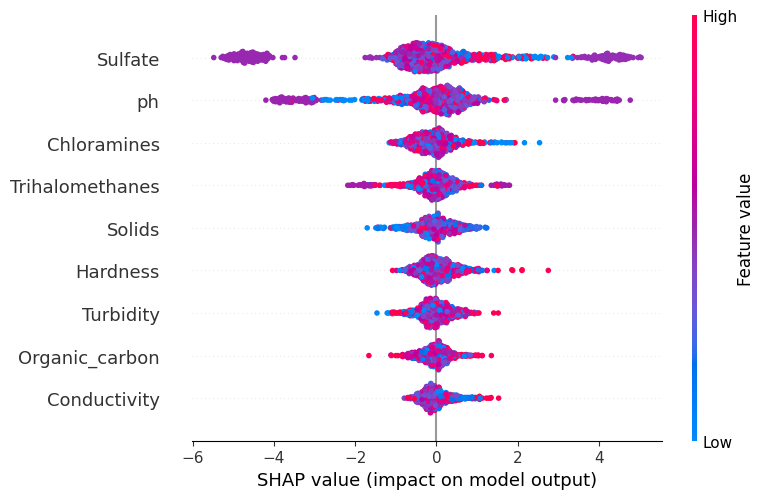

特徵排名:
           Feature   Importance
4          Sulfate  1537.761108
0               ph   983.161560
3      Chloramines   347.691345
7  Trihalomethanes   345.254150
2           Solids   333.570129
1         Hardness   304.054077
8        Turbidity   278.588531
6   Organic_carbon   240.798859
5     Conductivity   237.858810


In [6]:
# 使用SHAP解釋結果
# TreeExplainer為專門用於基於樹的模型（如 XGBoost)的解釋器
explainer = shap.TreeExplainer(model)
# shap_values為特徵對模型預測貢獻的數值
shap_values = explainer.shap_values(X_test)
# 生成 SHAP 值的可視化，展示哪些特徵對模型預測最為重要。
shap.summary_plot(shap_values, X_test)

# 特徵重要性排序
# 計算每個特徵的平均絕對 SHAP 值
mean_abs_shap_values = np.sum(np.abs(shap_values), axis=0)
# 建立特徵重要性表格
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': mean_abs_shap_values})
# 依據特徵重要性進行排序，sort_values(by='Importance')：根據 Importance 欄進行排序，ascending=False為醬序排列
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)


print("特徵排名:")
print(feature_importance)

# 特徵相關性

In [7]:
# 使用 Explanation 對象繪製瀑布圖
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value)

print(len(X_test))

# output_df = pd.DataFrame(columns=["Feature", "正數正相關","正數正相關%", "正數負相關", "正數負相關%", "正數無相關", "正數無相關%", "負數正相關", "負數正相關%", "負數負相關", "負數負相關%", "負數無相關", "負數無相關%", "正數", "負數", "Correlation"])
# 初始化變數
output_df = pd.DataFrame()
kk = 0
jj = 0
ll = 0
red_r = 0
blue_r = 0
red_l = 0
blue_l = 0
purple_r = 0
purple_l = 0
total = 0
p_n_offset = 0
related_offset = 0
related_offset_value = 0

related_red_r = 0
related_blue_r = 0
related_red_l = 0
related_blue_l = 0
related_purple_r = 0
related_purple_l = 0

maxvalue = float('-inf')  # 初始最大值設為負無窮
minvalue = float('inf')   # 初始最小值設為正無窮

# for w in range(1):
# 對特徵重要性表的每個特徵w進行分析
for w in range(len(feature_importance.Feature)):
    mean = X_test.iloc[0:,w].mean() # 計算測試及中特徵的平均值
    # 遍歷測試集內所有樣本i
    for i in range(len(X_test)):
#     for i in range(1):
        g_true = X_test.iloc[i,w] # 從第 i 個樣本中選擇特徵 w 的值，並將這個值存儲在變數。
        # 如果 g_true 大於當前的 maxvalue，則更新最大值。g_true 小於當前的 minvalue，則更新最小值。
        if i == 0: 
            maxvalue = g_true
            minvalue = g_true
        else:
            if g_true > maxvalue:
                maxvalue = g_true
            if g_true < minvalue:
                minvalue = g_true
        # 累計 SHAP 值的總貢獻與正負抵消
        explanation_ = explanation[i,w].values
        total = total+abs(explanation_)
        p_n_offset = p_n_offset+explanation_
        # 正負相關分類
        if explanation[i].values[w]>0:  #explanation大於0，所以會在global圖中的右邊
            kk +=1
            if g_true > mean:   # 特徵值大於平均值，視為正數正相關（紅色）
            #紅色的
                red_r+=1
                related_red_r += g_true
            elif g_true < mean: # 特徵值小於平均值，視為正數負相關（藍色）
            #藍色的
                blue_r+=1
                related_blue_r += g_true
            else:               # 特徵值等於平均值，視為正數無相關（紫色）
                purple_r+=1
                related_purple_r += g_true
        elif explanation[i].values[w]<0:  #explanation小於0，所以會在global圖中的左邊
            jj +=1
            if g_true > mean:   # 特徵值大於平均值，視為負數正相關（紅色）
            #紅色的
                red_l+=1
                related_red_l += g_true
            elif g_true < mean: # 特徵值小於平均值，視為負數負相關（藍色）
            #藍色的
                blue_l+=1
                related_blue_l += g_true
            else:               # 特徵值等於平均值，視為負數無相關(紫色)
                purple_l+=1
                related_purple_l += g_true
        else:                   # SHAP 值為 0，無相關
            ll +=1
    # 計算正負相關特徵值的總和        
    related_offset_value = (related_red_r+related_blue_l)+(related_blue_r+related_red_l)
    related_offset = (red_r+blue_l)-(blue_r+red_l)
    correlation = "正相關" if red_r+blue_l > blue_r+red_l else "負相關"  
    # 輸出特徵相關性統計
    print(feature_importance.Feature[w])
    print(f"正數正相關: {red_r:.0f} {red_r/(kk+jj+ll):.3f}")
    print(f"正數負相關: {blue_r:.0f} {blue_r/(kk+jj+ll):.3f}")
    print(f"正數無相關: {purple_r:.0f} {purple_r/(kk+jj+ll):.3f}")
    print(f"負數負相關: {red_l:.0f} {red_l/(kk+jj+ll):.3f}")
    print(f"負數正相關: {blue_l:.0f} {blue_l/(kk+jj+ll):.3f}")
    print(f"負數無相關: {purple_l:.0f} {purple_l/(kk+jj+ll):.3f}")
    print("正數:",kk)
    print("負數:",jj)
    print("0的值:",ll)
    print("總貢獻:",total)
    print("mean:",mean)
    print("global右左相抵消:",p_n_offset)
    print("正負相關值相抵消:",related_offset_value)
    print("正負相關相抵消:",related_offset)
    print("特徵屬性最大值:",maxvalue)
    print("特徵屬性最小值:",minvalue)

    # 將結果儲存到 DataFrame
    data = {
    "Feature": feature_importance.Feature[w],
    "正數正相關": f"{red_r:.0f}",
    "正數正相關%": f"{red_r/(kk+jj+ll):.3f}",
    "正數負相關": f"{blue_r:.0f}",
    "正數負相關%": f"{blue_r/(kk+jj+ll):.3f}",
    "正數無相關": f"{purple_r:.0f}",
    "正數無相關%": f"{purple_r/(kk+jj+ll):.3f}",
    "負數負相關": f"{red_l:.0f}",
    "負數負相關%": f"{red_l/(kk+jj+ll):.3f}",
    "負數正相關": f"{blue_l:.0f}",
    "負數正相關%": f"{blue_l/(kk+jj+ll):.3f}",
    "負數無相關": f"{purple_l:.0f}",
    "負數無相關%": f"{purple_l/(kk+jj+ll):.3f}",
    "正數": kk,
    "負數": jj,
    "0的值": ll,
    "global右左相抵消": p_n_offset,
    "正負相關值相抵消": related_offset_value,
    "正負相關相抵消": related_offset,
    "Correlation": correlation,
    "特徵屬性最大值": maxvalue,
    "特徵屬性最小值": minvalue
    }
    
    new_data = pd.DataFrame([data])
    output_df = pd.concat([output_df, new_data], ignore_index=True)
    # 處理完一個特徵後重置變數
    kk = 0
    jj = 0
    ll = 0
    red_r = 0
    blue_r = 0
    red_l = 0
    blue_l = 0
    purple_r = 0
    purple_l = 0
    total = 0 
    p_n_offset = 0
    related_offset = 0
    related_offset_value =0
    maxvalue = float('-inf')  # 初始最大值設為負無窮
    minvalue = float('inf')   # 初始最小值設為正無窮
    
# 打印DataFrame    
print(output_df)   

983
ph
正數正相關: 173 0.176
正數負相關: 317 0.322
正數無相關: 0 0.000
負數負相關: 314 0.319
負數正相關: 179 0.182
負數無相關: 0 0.000
正數: 490
負數: 493
0的值: 0
總貢獻: 983.1611195146106
mean: 0.00034068182995415706
global右左相抵消: -187.13909866241738
正負相關值相抵消: 0.33489023884521885
正負相關相抵消: -279
特徵屬性最大值: 4.139712386571702
特徵屬性最小值: -4.146796365176485
Hardness
正數正相關: 216 0.220
正數負相關: 237 0.241
正數無相關: 0 0.000
負數負相關: 279 0.284
負數正相關: 251 0.255
負數無相關: 0 0.000
正數: 453
負數: 530
0的值: 0
總貢獻: 304.05408392008394
mean: 0.0005988807309004084
global右左相抵消: 19.67445285152644
正負相關值相抵消: 0.9235899973204482
正負相關相抵消: -49
特徵屬性最大值: 3.904700326885872
特徵屬性最小值: -4.58766141671768
Solids
正數正相關: 254 0.258
正數負相關: 220 0.224
正數無相關: 0 0.000
負數負相關: 200 0.203
負數正相關: 309 0.314
負數無相關: 0 0.000
正數: 474
負數: 509
0的值: 0
總貢獻: 333.5702667461301
mean: -0.008171157335332791
global右左相抵消: -18.334633926249808
正負相關值相抵消: -7.10865766331176
正負相關相抵消: 143
特徵屬性最大值: 3.9978231093310255
特徵屬性最小值: -2.4454365602568813
Chloramines
正數正相關: 226 0.230
正數負相關: 205 0.209
正數無相關: 0 0.000
負數負相關: 2

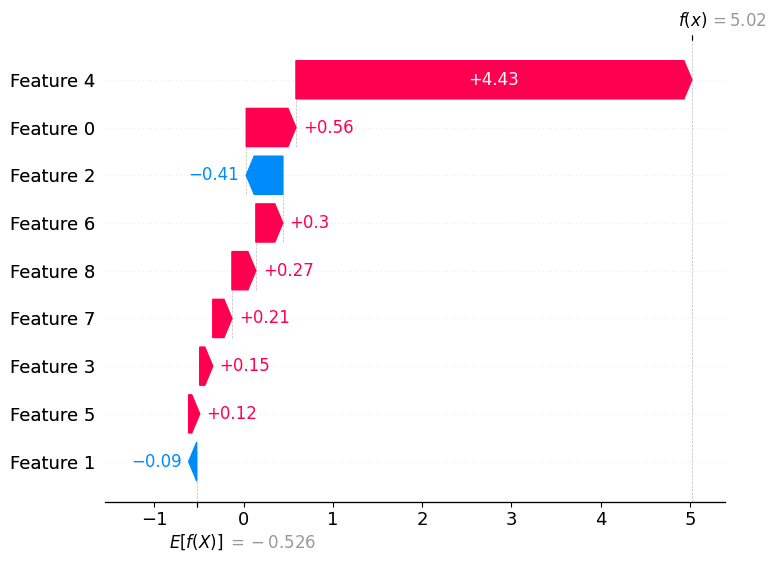

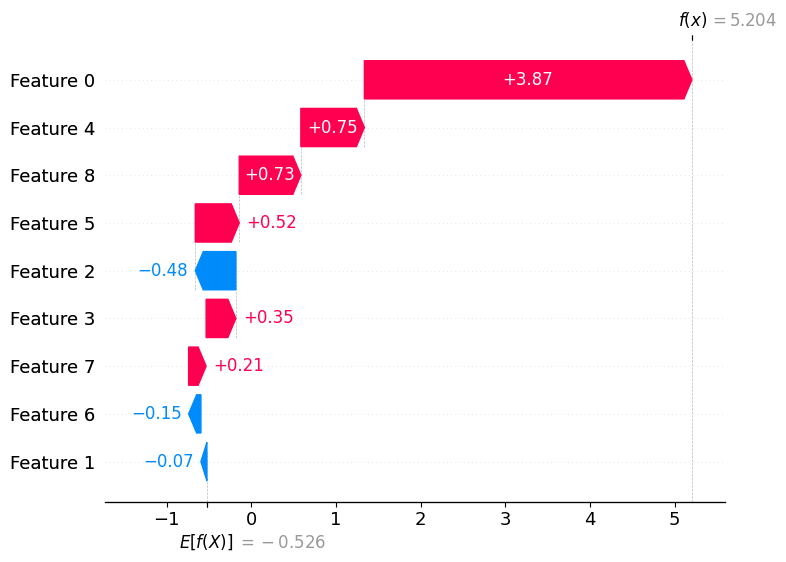

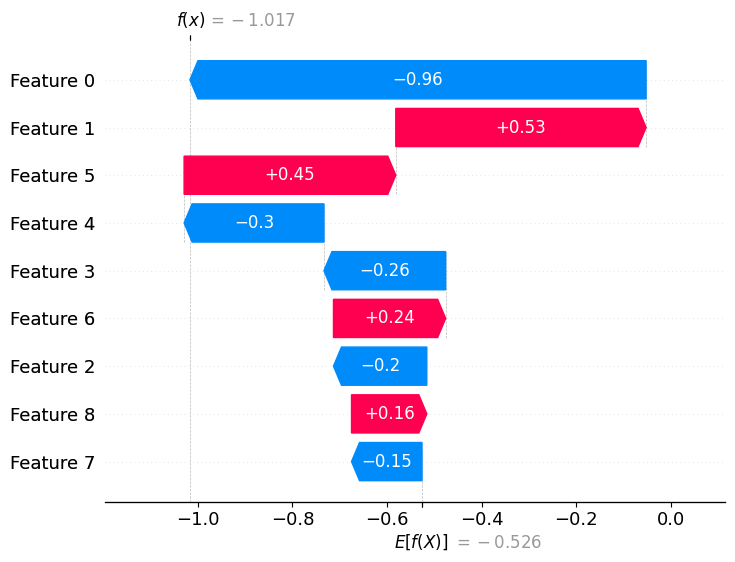

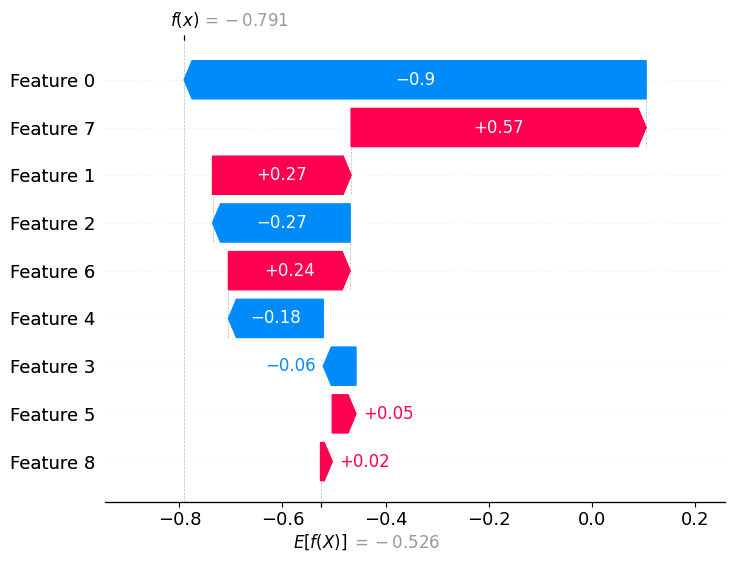

In [8]:
# 生成 SHAP 值的瀑布圖，逐一展示模型對前四個樣本的預測解釋。
shap.plots.waterfall(explanation[0])
shap.plots.waterfall(explanation[1])
shap.plots.waterfall(explanation[2])
shap.plots.waterfall(explanation[3])

In [9]:
# 存入CSV
output_df.to_csv("output_df_water.csv",encoding='big5')
output_df.to_csv("output_df_water_utf8.csv")

In [10]:
# 計算datadrame內中各個變數之間的Pearson相關係數矩陣
pearsoncorr = df.corr(method='pearson')
print(pearsoncorr)

                       ph  Hardness    Solids  Chloramines   Sulfate  \
ph               1.000000  0.075878 -0.081887    -0.031827  0.014785   
Hardness         0.075878  1.000000 -0.046899    -0.030054 -0.092718   
Solids          -0.081887 -0.046899  1.000000    -0.070148 -0.149809   
Chloramines     -0.031827 -0.030054 -0.070148     1.000000  0.023490   
Sulfate          0.014785 -0.092718 -0.149809     0.023490  1.000000   
Conductivity     0.017205 -0.023915  0.013831    -0.020486 -0.014196   
Organic_carbon   0.040092  0.003610  0.010242    -0.012653  0.027403   
Trihalomethanes  0.003009 -0.012718 -0.008849     0.016615 -0.025797   
Turbidity       -0.036211 -0.014449  0.019546     0.002363 -0.009523   
Potability      -0.003848 -0.013837  0.033743     0.023779 -0.026957   

                 Conductivity  Organic_carbon  Trihalomethanes  Turbidity  \
ph                   0.017205        0.040092         0.003009  -0.036211   
Hardness            -0.023915        0.003610        

<Axes: >

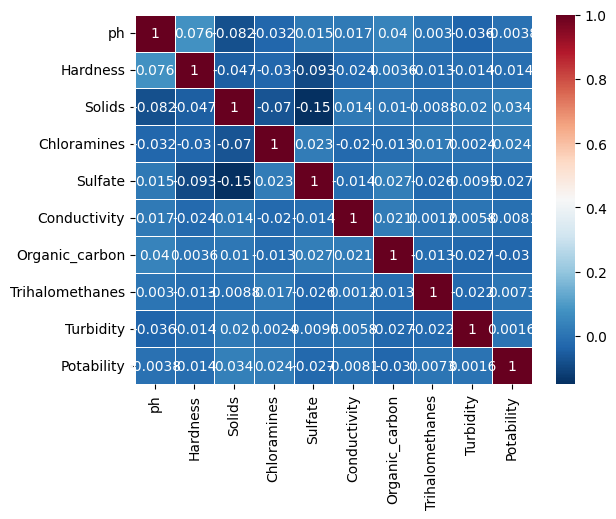

In [11]:
# 可視化Pearson 相關性矩陣
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [12]:
feature = pd.read_csv("output_df_water_utf8.csv")

print(feature[["Feature","正負相關值相抵消"]])

           Feature    正負相關值相抵消
0               ph    0.334890
1         Hardness    0.923590
2           Solids   -7.108658
3      Chloramines   34.783944
4          Sulfate   98.811195
5     Conductivity  115.245171
6   Organic_carbon  185.633933
7  Trihalomethanes  146.854241
8        Turbidity   91.181662


# Correlation

In [13]:

# 計算特徵與 Potability 的 Pearson 相關性
feature_importance.to_csv('feature_importance.csv', index=False)
# ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
feature_name = X_train.columns

if Dataset == 'water_potability':
    target_values = df['Potability'].dropna().astype(int)  # 去除空值
elif Dataset == 'water_quality':
    target_values = df['is_safe'].dropna().astype(int)  # 去除空值
    
for i in feature_name:
    
    feature_values = df[i].dropna().astype(float)  # 去除空值

    # 執行Pearson相關性檢驗
    correlation_coefficient, p_value = pearsonr(target_values, feature_values)

    # 打印结果
    print(f"\nCorrelation between Potability and {i}: {correlation_coefficient}")
    print(f"P-value: {p_value}") # 設立變數以便後續判斷檢查相關性是否有顯著性

    # 根據 p-value 判斷顯著性關係，例如 0.05
    if p_value < 0.05:
        print("存在著顯著關係")
    else:
        print("沒有顯著關係")


Correlation between Potability and ph: -0.003848192545448021
P-value: 0.825736219451172
沒有顯著關係

Correlation between Potability and Hardness: -0.013836558085111502
P-value: 0.42854158740865944
沒有顯著關係

Correlation between Potability and Solids: 0.03374331339365007
P-value: 0.0534636381845037
沒有顯著關係

Correlation between Potability and Chloramines: 0.023778971994669704
P-value: 0.17361022465074868
沒有顯著關係

Correlation between Potability and Sulfate: -0.02695703227768173
P-value: 0.12292453703924656
沒有顯著關係

Correlation between Potability and Conductivity: -0.008128319721545504
P-value: 0.6418845485973539
沒有顯著關係

Correlation between Potability and Organic_carbon: -0.030001366610944716
P-value: 0.08599746163873917
沒有顯著關係

Correlation between Potability and Trihalomethanes: 0.007304743131624094
P-value: 0.6759888897938863
沒有顯著關係

Correlation between Potability and Turbidity: 0.0015806819539223296
P-value: 0.9279391620837841
沒有顯著關係


In [14]:
# X_test.to_csv('X_test.csv')
# test_test_x = pd.read_csv('X_test.csv')
# shap_x = explanation.values
# print(len(test_test_x))
# print(len(shap_x))
# # 提取所需的資料列
# print(test_test_x.columns)


# # 遍歷特徵名稱列表並提取相應的數據
# for index, feature_name in enumerate(feature_names):
#     # 提取相應的資料列
#     shap_feature = shap_x[:, index]
#     test_feature = test_test_x[feature_name]
#     # 計算Pearson相關係數
#     correlation_coefficient, p_value = pearsonr(shap_feature, test_feature)
#     print(index)
#     print("特徵:", feature_name)
#     print("Pearson相關係數:", correlation_coefficient)
#     print("p值:", p_value)

#     # 根據 p-value 判斷顯著性關係，例如 0.05
#     if p_value < 0.05:
#         print("存在著顯著關係")
#     else:
#         print("沒有顯著關係")
#     print("-----------------------------------")  